In [36]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
import os

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_largest_companies_in_Africa_by_revenue'
headers = {"User-Agent": "Mozilla/5.0"}
page = requests.get(url, headers=headers)

In [3]:
soup = BeautifulSoup(page.text, 'html.parser')
overall_data = []

In [4]:
headers = soup.find_all('tr')[1]
header_titles = [title.text.strip() for title in headers.find_all('th')]

In [5]:
rows = soup.find_all('tr')[2:]
for row in rows:
    ind_row = row.find_all('td')
    row_data = [row_info.text.strip() for row_info in ind_row]
    overall_data.append(row_data)

In [6]:
df = pd.DataFrame(overall_data, columns=header_titles)
os.makedirs('Top African Companies')
# df.to_csv(r"Top African Companies\Top African Companies.csv", index=False)

In [7]:
df['Revenue(US$ billions)'] = pd.to_numeric(df['Revenue(US$ billions)'], errors='coerce')

In [8]:
most_companies_by_country = df.filter(items = ['Rank', 'Headquarters']).groupby('Headquarters').count().sort_values(by='Rank', ascending=False)
biggest_revenue_by_country = df.groupby('Headquarters').agg(Revenue_Sum=('Revenue(US$ billions)', 'sum')).sort_values(by='Revenue_Sum', ascending=False)
biggest_revenue_by_industry = df.groupby('Industry').agg(Revenue_Sum=('Revenue(US$ billions)', 'sum')).sort_values(by='Revenue_Sum', ascending=True)

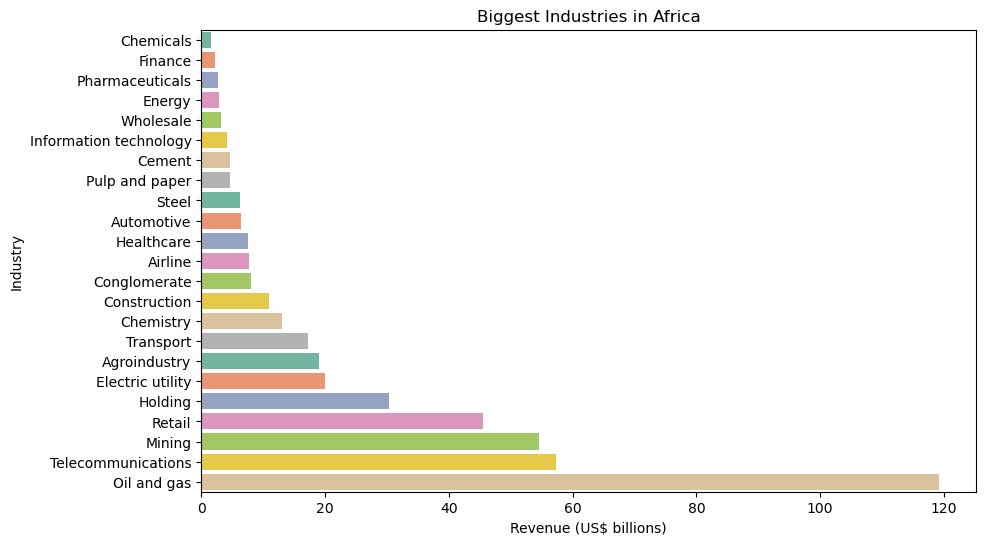

In [9]:
x_values = biggest_revenue_by_industry.squeeze()  
y_labels = biggest_revenue_by_industry.index  

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=x_values, y=y_labels, hue=y_labels, palette="Set2", legend=False) # palette="Set2", "tab10", "pastel"

ax.set_title("Biggest Industries in Africa")
ax.set_xlabel("Revenue (US$ billions)")

plt.savefig(r"Top African Companies\biggest_industries.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

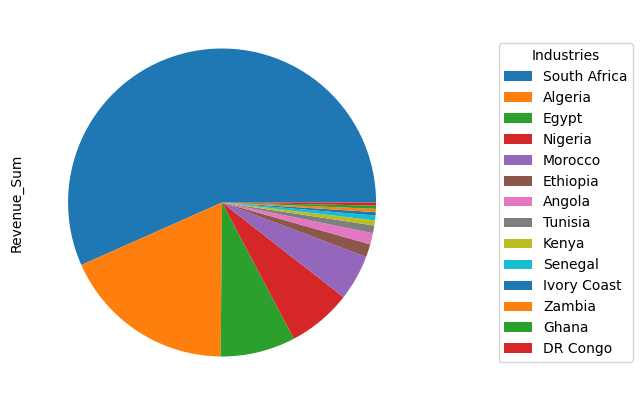

In [10]:
ax = biggest_revenue_by_country.plot.pie(
    y='Revenue_Sum',
    figsize=(10, 5),
    labels=None,
    autopct=None,
)
ax.legend(
    labels=biggest_revenue_by_country.index,
    title="Industries",
    bbox_to_anchor=(1.2, 0.5),
    loc="center left"
)
plt.savefig(r"Top African Companies\biggest_industries_pie_chart.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

<Figure size 800x500 with 0 Axes>

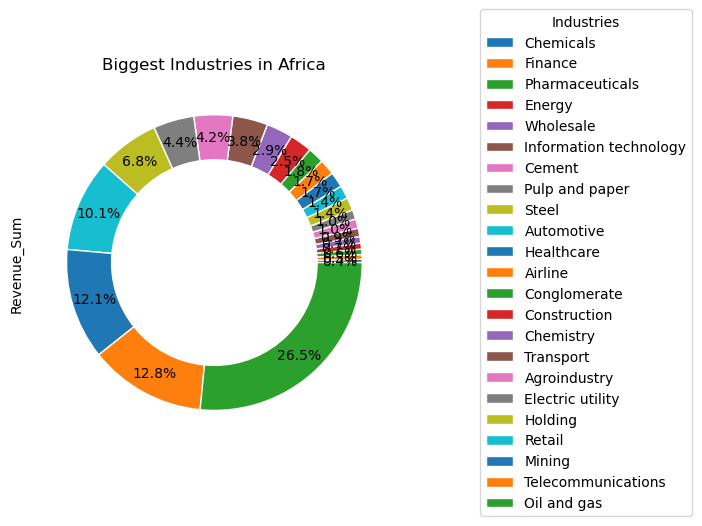

In [11]:
plt.figure(figsize=(8, 5))
ax = biggest_revenue_by_industry.plot.pie(
    y='Revenue_Sum', 
    labels=None, 
    autopct='%1.1f%%', 
    wedgeprops={'edgecolor': 'white'},
    pctdistance=0.85
)
center_circle = plt.Circle((0,0), 0.70, fc='white')
plt.gca().add_artist(center_circle)

ax.legend(labels=biggest_revenue_by_industry.index, title="Industries", bbox_to_anchor=(1.2, 0.5), loc="center left")

plt.title("Biggest Industries in Africa")
plt.savefig(r"Top African Companies\biggest_industries_donut_chart.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

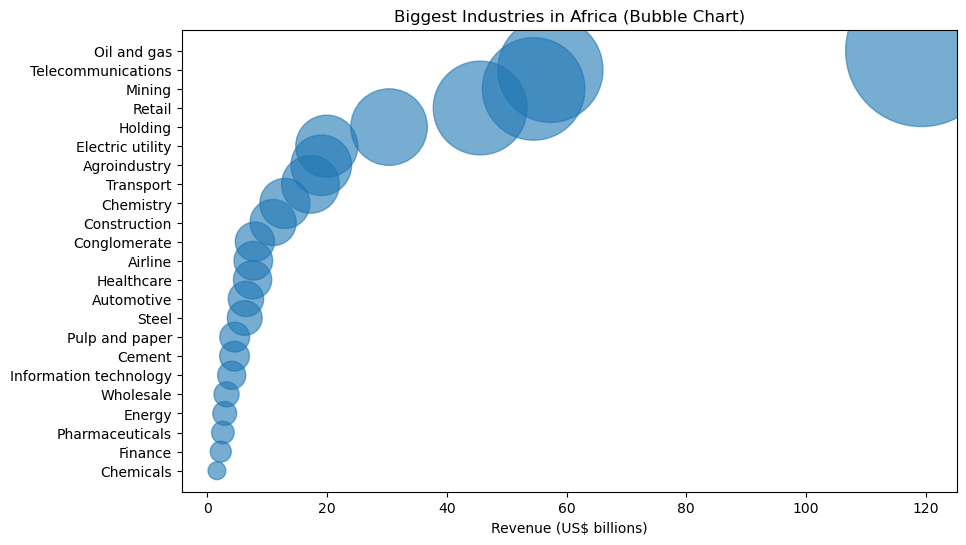

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(
    x=biggest_revenue_by_industry['Revenue_Sum'], 
    y=biggest_revenue_by_industry.index, 
    s=biggest_revenue_by_industry['Revenue_Sum'] * 100,
    alpha=0.6
)

plt.xlabel("Revenue (US$ billions)")
plt.title("Biggest Industries in Africa (Bubble Chart)")
plt.savefig(r"Top African Companies\biggest_industries_bubble.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [13]:
# Pivot Tables
revenue_by_industry_pivot = df.pivot_table(values='Revenue(US$ billions)', index='Industry', aggfunc='sum').sort_values(by='Revenue(US$ billions)', ascending=False)
revenue_by_country_pivot = df.pivot_table(values='Revenue(US$ billions)', index='Headquarters', aggfunc='sum').sort_values(by='Revenue(US$ billions)', ascending=False)

companies_in_each_industry_pivot = df.pivot_table(values='Company', index='Industry', aggfunc='count').sort_values(by='Company', ascending=False)
average_revenue_per_country_in_each_industry_pivot = df.pivot_table(values='Revenue(US$ billions)', index='Industry', aggfunc='mean').sort_values(by='Revenue(US$ billions)', ascending=False)

revenue_breakdown_by_country_and_industry_pivot = df.pivot_table(values='Revenue(US$ billions)', index='Headquarters', columns='Industry', aggfunc='sum', fill_value=0)
top_companies_by_revenue_in_each_industry_pivot = df.loc[df.groupby('Industry')['Revenue(US$ billions)'].idxmax(), ['Industry', 'Company', 'Revenue(US$ billions)']]

revenue_share_of_each_industry_within_a_country_pivot = df.pivot_table(values='Revenue(US$ billions)', index='Industry', columns='Headquarters', aggfunc='sum', fill_value=0)
revenue_share_of_each_industry_within_a_country_pivot = revenue_share_of_each_industry_within_a_country_pivot.div(revenue_share_of_each_industry_within_a_country_pivot.sum(axis=0), axis=1) * 100

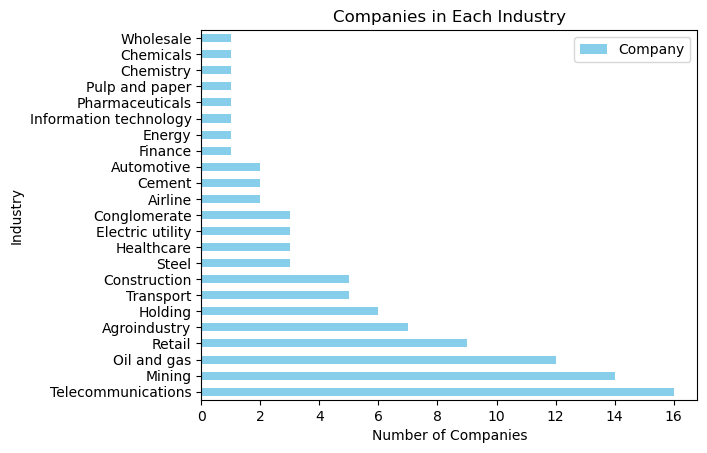

In [14]:
companies_in_each_industry_pivot.plot.barh(color='skyblue')

plt.title('Companies in Each Industry')
plt.xlabel('Number of Companies')

plt.savefig(r"Top African Companies\most_companies.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

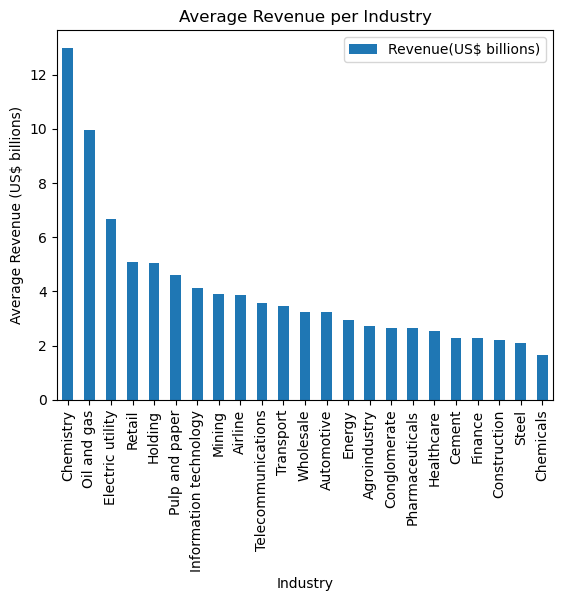

In [15]:
average_revenue_per_country_in_each_industry_pivot.plot(kind='bar')

plt.title('Average Revenue per Industry')
plt.ylabel('Average Revenue (US$ billions)')

plt.savefig(r"Top African Companies\average_revenue.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [16]:
with pd.ExcelWriter(r"Top African Companies\top_african_countries.xlsx", engine="xlsxwriter") as writer:
    revenue_by_industry_pivot.to_excel(writer, sheet_name="Revenue by Industry")
    revenue_by_country_pivot.to_excel(writer, sheet_name="Revenue by Country")
    companies_in_each_industry_pivot.to_excel(writer, sheet_name="Companies per Industry")
    average_revenue_per_country_in_each_industry_pivot.to_excel(writer, sheet_name="Avg Revenue per Industry")
    revenue_breakdown_by_country_and_industry_pivot.to_excel(writer, sheet_name="Revenue by Country & Industry")
    top_companies_by_revenue_in_each_industry_pivot.to_excel(writer, sheet_name="Top Companies by Industry")
    revenue_share_of_each_industry_within_a_country_pivot.to_excel(writer, sheet_name="Industry Distribution p Country")
    
    workbook = writer.book
    
    worksheet = workbook.get_worksheet_by_name("Revenue by Industry")
    worksheet.insert_image("D2", r"Top African Companies\biggest_industries.png")
    worksheet = workbook.get_worksheet_by_name("Revenue by Country")
    worksheet.insert_image("D2", r"Top African Companies\biggest_industries_pie_chart.png")
    worksheet = workbook.get_worksheet_by_name("Companies per Industry")
    worksheet.insert_image("D2", r"Top African Companies\most_companies.png")
    worksheet = workbook.get_worksheet_by_name("Avg Revenue per Industry")
    worksheet.insert_image("D2", r"Top African Companies\average_revenue.png")
    worksheet = workbook.add_worksheet("Visualizations")

    worksheet.insert_image("B2", r"Top African Companies\biggest_industries_donut_chart.png")
    worksheet.insert_image("B29", r"Top African Companies\biggest_industries_bubble.png")

    writer._save()

C:\Users\Bruce\anaconda3\Lib\site-packages\xlsxwriter\workbook.py:377: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
